<a href="https://colab.research.google.com/github/unjuken/DeepQ-RubiksCube/blob/main/Aprendizaje_Profundo_202110_Taller_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

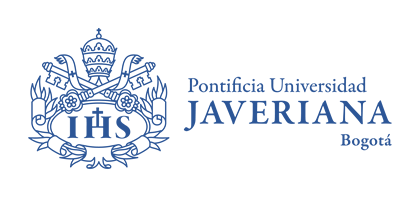

# Aprendizaje profundo - Taller 2
Este notebook tiene como objetivo familiarizar al estudiante con un ambiente de aprendizaje por refuerzo bajo el API de OpenAI Gym



En el segundo taller del curso se utilizará el framework OpenAI Gym y Tensorflow Agents para crear una red neuronal profunda que resuelva un cubo de rubik de 2x2x2 utilizando el gimnasio RubiksCubeGym disponible [en github siguiendo este link](https://github.com/DoubleGremlin181/RubiksCubeGym)



Este notebook utiliza instrucciones del tutorial **Train a Deep Q Network with TF-Agents** disponible en este [link](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=pmDI-h7cI0tI)  


## Setup
Se instalan y se importan las librerías necesarias para el ejercicio

In [1]:
%load_ext tensorboard
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install rubiks-cube-gym

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,769 kB]
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:13 https://developer.download

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [3]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Exploración del ambiente

En las siguientes celdas se explora el ambiente rubiks cube, cómo se visualiza el cubo y las acciones que se pueden aplicar al cubo

In [4]:
env_name='rubiks-cube-222-v0'

In [5]:
import rubiks_cube_gym

In [6]:
env = suite_gym.load(env_name)
env.reset()

State file not found
Downloading...


HTTPError: ignored

Una vez cargado el gimnasio, se puede visualizar el estado del cubo, el cubo inicia con un estado aleatorio

In [8]:
# Visualización como imagen del entorno
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)

NameError: ignored

In [ ]:
# Visualización del entorno como string de resumen
env.cube_reduced 

In [ ]:
# Visualización del entorno como arreglo RGB
env.render()

El cubo se puede inicializar en alguna configuración por defecto también utilizando la notación [WCA disponible en este link](https://www.worldcubeassociation.org/regulations/#article-12-notation)

El método de reset con parámetros no esta disponible en el api de tf_agents, por lo que se inicializa el ambiente en este caso utilizando gym

In [10]:
import gym
env_gym = gym.make(env_name)  
env_gym.reset(scramble="R U R' U' R' F R2 U' R' U' R U R' F'") 
env_gym.cube_reduced


State file not found
Downloading...


HTTPError: ignored

In [ ]:
PIL.Image.fromarray(env_gym.render(mode='rgb_array')).resize((300,200),PIL.Image.BOX)

In [11]:
# Ambiente con cubo ordenado
import gym
env_gym_ordered = gym.make(env_name)  
env_gym_ordered.reset(scramble="R R'") 
env_gym_ordered.cube_reduced

State file not found
Downloading...


HTTPError: ignored

In [ ]:
PIL.Image.fromarray(env_gym_ordered.render(mode='rgb_array')).resize((300,200),PIL.Image.BOX)



## Acciones, espacio de observación y recompensas en tf-agents

El método `time_step_spec()`retorna la especificación del ambiente para avanzar un paso en el tiempo el ambiente.

`observation` indica las posibles combinaciones del cubo que existen: 3674160



In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)

`reward` indica la configuración de la recompensa, en este caso es un float

In [ ]:
print('Reward Spec:')
print(env.time_step_spec().reward)

El método `action_spec()` retorna las acciones válidas sobre el ambiente. En este caso se tienen 3 acciones que rotar 90 grados en sentido de las agujas del reloj la siguiente superficie del cubo:

*   0 indica girar la cara frontal del cubo
*   1 indica girar la cara derecha del cubo
*   2 indica girar la cara superior del cubo



In [ ]:
print('Action Spec:')
print(env.action_spec())

In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)


In [ ]:
env.cube_reduced


In [ ]:
action = np.array(1, dtype=np.int32)
next_time_step = env.step(action)

print('Next time step:')
print(next_time_step)

In [ ]:
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)

In [ ]:
env.cube_reduced

Note que la recomensa para los pasos dados con las acciones es -1, esto se debe a que el ambiente por defecto retorna -1 a menos que el cubo este completamente ordenado. Revise el siguiente [link](https://github.com/DoubleGremlin181/RubiksCubeGym/blob/master/rubiks_cube_gym/envs/rubiks_cube_222.py#L105) en la función `reward(self,action)` del ambiente.

 

## Extendiendo el ambiente por defecto para incluir una función de recompensa propia

Para extender el ambiente por defecto se debe extender la clase  `RubiksCube222Env` y reimplementar el método `reward(self,action)` 



In [ ]:
from rubiks_cube_gym.envs.rubiks_cube_222 import  RubiksCube222Env

Se crea una clase nueva que retorna una recompensa proporcional al número de casillas correctas en el cubo.

In [ ]:
class NaiveRubiksCube222(RubiksCube222Env):
  solved="WWWWOOGGRRBBOOGGRRBBYYYY"
  def __init__(self):
        super(NaiveRubiksCube222, self).__init__()

  def reward(self):
    
    if self.cube_reduced == self.solved:
      return 100,True
    reward=0  
    for i in range(0,len(self.cube_reduced)):
      reward+=self.solved[i]==self.cube_reduced[i]
    return reward, False

from gym.envs.registration import register

register(
    id='naive-rubiks-cube-222-v0',
    entry_point='__main__:NaiveRubiksCube222',
    max_episode_steps=250,
)


In [ ]:
class OneFaceFirstRubiksCube222(RubiksCube222Env):
  solved="WWWWOOGGRRBBOOGGRRBBYYYY"
  def __init__(self):
        super(OneFaceFirstRubiksCube222, self).__init__()

  def reward(self):
    #reward=0  
    #for i in [2,3,5,6,7,8,13,14,15,16,20,21] :
    #  reward+= (self.solved[i]==self.cube_reduced[i])*10
    #if (reward == 120): 
    #  return reward, True
    #return reward, False
    if self.cube_reduced == self.solved:
      return 10000, True
    else:
      reward=0  
      for i in range(0,len(self.cube_reduced)):
        reward+=self.solved[i]==self.cube_reduced[i]
      return reward, False
    
  
  def reset(self):
    return RubiksCube222Env.reset(self, scramble="R")


from gym.envs.registration import register

register(
    id='OneFaceFirstRubiksCube222-v6',
    entry_point='__main__:OneFaceFirstRubiksCube222',
    max_episode_steps=250,
)

In [ ]:
import math

class ManhattanRubiksCube222(RubiksCube222Env):
  solved="WWWWOOGGRRBBOOGGRRBBYYYY"
  #"**WW*OGGR****OGGR***YY**"
  def __init__(self):
        super(OneFaceFirstBRubiksCube222, self).__init__()

  def reward(self):
    reward=0 
    pow = 0
    for i in [2,3,5,6,7,8,13,14,15,16,20,21]:
      pow+=self.solved[i]==self.cube_reduced[i]
    if pow == 12:
      return 10000, True
    else:    
      reward = math.pow(2, pow)
      return reward, False


from gym.envs.registration import register

register(
    id='ManhattanRubiksCube222-v2',
    entry_point='__main__:ManhattanRubiksCube222',
    max_episode_steps=250,
)

In [ ]:
import math

class VerticesRubiksCube222(RubiksCube222Env):
  solved="WWWWOOGGRRBBOOGGRRBBYYYY"
  stage = 0
  vertex=[
          [2, 6, 5], #frontal superior izquierdo
          [3, 8, 7], #frontal superior derecho
          [14, 20, 13], #frontal inferior izquierdo
          [15, 16, 21], #frontal inferior Derecho
          [0, 4, 11], #trasero superior izquierdo
          [1, 10, 9], #trasero superior derecho
          [12, 22, 19], #trasero Inferior izquierdo
          [17, 18, 23]  #trasero Inferior derecho
          ]
  
  vertexColor = [ "WGO", "WRG", "GYO", "GRY", "WOB", "WBR", "OYB", "RBY" ]
  vertexColorExtended = [ "WGOWG", "WRGWR", "GYOGY", "GRYGR", "WOBWO", "WBRWB", "OYBOY", "RBYRB" ]

  m_right = [1, 5, 7, 3]
  m_up = [0, 4, 5, 1]
  m_front = [0, 1, 3, 2]

  distances = [
               [0, 0, 0],
               [0, 1, 1],
               [0, 2, 3],
               [0, 3, 2],
               [0, 4, 1],
               [0, 5, 2],
               [0, 7, 3],
               [1, 0, 1],
               [1, 1, 0],
               [1, 2, 2],
               [1, 3, 1],
               [1, 4, 2],
               [1, 5, 1],
               [1, 7, 2],
               [2, 0, 1],
               [2, 1, 2],
               [2, 2, 0],
               [2, 3, 3],
               [2, 4, 2],
               [2, 5, 3],
               [2, 7, 4],
               [3, 0, 2],
               [3, 1, 1],
               [3, 2, 1],
               [3, 3, 0],
               [3, 4, 3],
               [3, 5, 2],
               [3, 7, 3],
               [4, 0, 3],
               [4, 1, 2],
               [4, 2, 4],
               [4, 3, 3],
               [4, 4, 0],
               [4, 5, 1],
               [4, 7, 2],
               [5, 0, 2],
               [5, 1, 1],
               [5, 2, 3],
               [5, 3, 2],
               [5, 4, 3],
               [5, 5, 0],
               [5, 7, 1],
               [7, 0, 2],
               [7, 1, 1],
               [7, 2, 3],
               [7, 3, 2],
               [7, 4, 3],
               [7, 5, 1],
               [7, 7, 0]
  ]

  # Tabla de distancias.
  # (0, 1) = 1
  # (0, 2) = 3
  # (0, 3) = 2
  # (0, 4) = 1
  # (0, 5) = 2
  # (0, 7) = 3

  # (1, 0) = 1
  # (1, 2) = 2
  # (1, 3) = 1
  # (1, 4) = 2
  # (1, 5) = 1
  # (1, 7) = 2

  # (2, 0) = 1
  # (2, 1) = 2
  # (2, 3) = 3
  # (2, 4) = 2
  # (2, 5) = 3
  # (2, 7) = 4

  # (3, 0) = 2
  # (3, 1) = 1
  # (3, 2) = 1
  # (3, 4) = 3
  # (3, 5) = 2
  # (3, 7) = 3

  # (4, 0) = 3
  # (4, 1) = 2
  # (4, 2) = 4
  # (4, 3) = 3
  # (4, 5) = 1
  # (4, 7) = 2


  # (5, 0) = 2
  # (5, 1) = 1
  # (5, 2) = 3
  # (5, 3) = 2
  # (5, 4) = 3
  # (5, 7) = 1

  # (7, 0) = 2
  # (7, 1) = 1
  # (7, 2) = 3
  # (7, 3) = 2
  # (7, 4) = 3
  # (7, 5) = 1
  
  def __init__(self):
        super(VerticesRubiksCube222, self).__init__()

  def reward(self):
    distances = self.get_distances_array()
    sum = 0
    for i in range(0, len(distances)):    
      sum = sum + distances[i];    

    if sum == 0:
      return 100, True
    else:
      reward = 0
      correct  = 0
      totaldis = 0
      for idx, dist in enumerate(distances):
        if dist == 0 and idx < 4: 
          correct+=1
        elif idx < 4:
          totaldis += dist

      reward += (correct * 20)
      reward -= math.pow(2, dist)
      if reward <= 0: reward = -1
      return reward, False
  
  def get_current_vertex(self):
    current_vertex = []
    for ver in self.vertex:
      verString = ''
      for pos in ver:
        verString += self.cube_reduced[pos]
      #endfor
      current_vertex.append(verString)
    #endfor
    return current_vertex
  #enddef

  def get_diff(self):
    current  = self.get_current_vertex()
    c_e = self.vertexColorExtended 
    distances = []
    for ic, c in enumerate(current):
      for ireg, reg in enumerate(c_e):
        if c in reg: distances.append([ic, ireg])
    return distances

  def get_distances_array(self):
    disArray = self.distances
    diff = self.get_diff()
    distances = []
    for id_current, current_diff in enumerate(diff):
      for idx, tem_dis in enumerate(disArray):
        pos1 = tem_dis[0]
        pos2 = tem_dis[1]
        if  pos1 == current_diff[0] and pos2 == current_diff[1]:
          distances.append( tem_dis[2] )
    return distances

#Codificar cada vertice con letras de color
#Encontrar donde deberia estar ese vertice.
#Generar una distancia? 
#devolver un reward


from gym.envs.registration import register

register(
    id='VerticesRubiksCube222-v15',
    entry_point='__main__:VerticesRubiksCube222',
    max_episode_steps=250,
)

In [ ]:
env = suite_gym.load('VerticesRubiksCube222-v15')
env.reset()


In [ ]:
current  = env.get_current_vertex()
c_e = env.vertexColorExtended

diff = env.get_diff()
distarray = env.get_distances_array()

print(distarray)
print(diff)
print(current)
print(c_e)
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)



In [ ]:
#@title 
time_step = env_naive.reset()
print('Time step:')
print(time_step)
PIL.Image.fromarray(env_naive.render()).resize((300,200),PIL.Image.BOX)

In [ ]:
#@title 
action = np.array(1, dtype=np.int32)
next_time_step = env_naive.step(action)

print('Next time step:')
print(next_time_step)

In [ ]:
#@title
PIL.Image.fromarray(env_naive.render()).resize((300,200),PIL.Image.BOX)

## Entrenamiento y ajuste de redes neuronales profundas con el agente

Para continuar con el taller, revise el notebook **Train a Deep Q Network with TF-Agents** disponible en este [link](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=pmDI-h7cI0tI). Allí se muestra como crear un agente de TensorFlow a partir de un gimnasio de OpenAI gym, el entrenamiento y test de una red Deep Q Network. 

**Funciones de ayuda para facilitar el entrenamiento y la experimentación**:

In [ ]:
#@title 
from  tf_agents.networks  import  q_network 
import numpy as np

def createEnvironments(env_name):
  train_py_env = suite_gym.load(env_name)
  eval_py_env = suite_gym.load(env_name)
  train_env = tf_py_environment.TFPyEnvironment(train_py_env)
  eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)
  return train_py_env, eval_py_env, train_env, eval_env

def createQNet(train_env, fc_layer_params = (100 ,100), activation_fn = tf.keras.activations.relu,  dropout_layer_params = None):
  q_net = q_network.QNetwork( train_env.observation_spec(), train_env.action_spec(), fc_layer_params=fc_layer_params, activation_fn = activation_fn, dropout_layer_params = dropout_layer_params) 
  return q_net

def create_and_init_agent(train_env, q_net, optimizer, gamma = 0.9, epsilon_greedy = 0.1):
  train_step_counter = tf.Variable(0)
  agent = dqn_agent.DqnAgent(
      train_env.time_step_spec(),
      train_env.action_spec(),
      q_network=q_net,
      optimizer=optimizer,
      td_errors_loss_fn=common.element_wise_squared_loss,
      gamma = gamma,
      epsilon_greedy = epsilon_greedy
      )
  agent.initialize()
  return agent

#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see tutorial 4 or the drivers module.
# https://github.com/tensorflow/agents/blob/master/docs/tutorials/4_drivers_tutorial.ipynb 
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers


def prepare_environment_for_training(env_name = 'rubiks-cube-222-v0', fc_layer_params = (100 ,100), activation_fn = tf.keras.activations.relu,  dropout_layer_params = None, learning_rate = 0.1, optimizer_type = tf.keras.optimizers.Adam, gamma = 0.9, epsilon_greedy = 0.1):
  optimizer = optimizer_type(learning_rate = learning_rate)
  train_py_env, eval_py_env, train_env, eval_env = createEnvironments(env_name)
  q_net = createQNet(train_env, fc_layer_params, activation_fn, dropout_layer_params)
  agent = create_and_init_agent(train_env, q_net, optimizer, gamma, epsilon_greedy)
  q_net.summary()
  eval_policy = agent.policy
  collect_policy = agent.collect_policy
  random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(data_spec=agent.collect_data_spec, batch_size=train_env.batch_size, max_length=replay_buffer_max_length)
  collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)
  # Dataset generates trajectories with shape [Bx2x...]
  dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)
  iterator = iter(dataset)
  return train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator

def train_environment(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration, eval_interval, log_interval):
  try:
    %%time
  except:
    pass

  # (Optional) Optimize by wrapping some of the code in a graph using TF function.
  agent.train = common.function(agent.train)
  # Reset the train step
  agent.train_step_counter.assign(0)
  # Evaluate the agent's policy once before training.
  avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
  returns = [avg_return]
  losses = []
  for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    if step % log_interval == 0:
      print('step = {0}: loss = {1}'.format(step, train_loss))
      losses.append(train_loss)
    if step % eval_interval == 0:
      avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
      print('step = {0}: Average Return = {1}'.format(step, avg_return))
      returns.append(avg_return)
  return returns, losses

def plot_training(num_iterations, eval_interval, log_interval, returns, losses):
  iterations = range(0, num_iterations + 1, eval_interval)
  plt.figure()  
  plt.plot(iterations, returns)
  plt.ylabel('Average Return')
  plt.xlabel('Iterations') 
  iterations = range(log_interval, num_iterations + 1, log_interval)
  plt.figure()  
  plt.plot(iterations, losses)
  plt.ylabel('Loss')
  plt.xlabel('Iterations') 


def train_environment_and_plot(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration, eval_interval, log_interval):
  returns, losses = train_environment(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration,  eval_interval, log_interval)
  plot_training(num_iterations, eval_interval, log_interval, returns, losses)
  return returns

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(eval_env, policy, filename, num_episodes=5, fps=2):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      im = PIL.Image.fromarray(eval_py_env.render()).resize((300,200),PIL.Image.BOX)
      video.append_data(np.array(im))
      while not (time_step.is_last()):
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        im = PIL.Image.fromarray(eval_py_env.render()).resize((300,200),PIL.Image.BOX)
        video.append_data(np.array(im))
  return embed_mp4(filename)


## Prueba inicial con el reward por defecot del gym y dos capas densas de 100 neuronas. 

Como se puede apreciar en el video al final, el entrenamiento no es suficiente y la politica "aprendida" es mover siempre la cara frontal.

In [ ]:
env_name = "rubiks-cube-222-v0" #@param {type:"string"}
fc_layer_params = (100 ,100) #@param {type:"raw"}
activation_fn = tf.keras.activations.relu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}

num_iterations = 20000 # @param {type:"integer"} 

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

optimizer = optimizer_type(learning_rate=learning_rate)



#Configurar, entrenar, y mostrar gráfica
train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(env_name, fc_layer_params, activation_fn,  dropout_layer_params, optimizer)
returns = train_environment(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration, eval_interval)
plot_training(num_iterations, eval_interval, returns)

In [ ]:

create_policy_eval_video(agent.policy, "trained-agent")


Ahora cambiamos el ambiente a "naive-rubiks-cube-222-v0" para probar el efecto con una función de recomenza diferente, aunque parece que el reward es mayaor con el paso del tiempo, la politica final aplicada por el agente resulta mover siempre la cara derecha, como se puede apreciar en el video)

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  10300     
_________________________________________________________________
dense_32 (Dense)             multiple                  303       
Total params: 10,603
Trainable params: 10,603
Non-trainable params: 0
_________________________________________________________________
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs
step = 200: loss = 98476.46875
step = 400: loss = 2137.135986328125
step = 600: loss = 1916.3363037109375
step = 800: loss = 31026.86328125
step = 1000: loss = 6164.3818359375
step = 1000: Average Return = 1719.0
step = 1200: loss = 44554.046875
step = 1400: loss = 3715.470703125
step = 1600: loss = 101480.375
step = 1800: loss = 2570256.25
step = 2000: loss = 73507872.0
step = 2000: Average Return = 1468.300048828125
step = 2200: loss = 387517

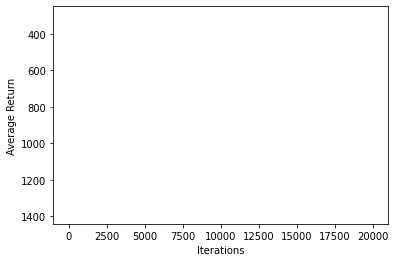

In [ ]:

env_name = "naive-rubiks-cube-222-v0" #@param {type:"string"}
fc_layer_params = (100 ,100) #@param {type:"raw"}
activation_fn = tf.keras.activations.relu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}

num_iterations = 20000 # @param {type:"integer"} 

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

optimizer = optimizer_type(learning_rate=learning_rate)



#Configurar, entrenar, y mostrar gráfica
train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(env_name, fc_layer_params, activation_fn,  dropout_layer_params, optimizer)
returns = train_environment(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration, eval_interval)
plot_training(num_iterations, eval_interval, returns)

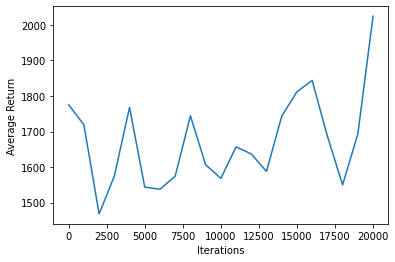

In [ ]:
plot_training(num_iterations, eval_interval, returns)

In [ ]:
create_policy_eval_video(agent.policy, "trained-agent")

Vamos a probar con 100000 iteraciones y batch size de 1000, para ver si el resultado cambia al tener muchos mas experimentos.
Como se puede apreciar el reward oscila en un aproximado de 1700, pero no se ve una tendencia a maximizarse, pero por otro lado la perdida si se estabilizó en un valor cercano a 55. 
En el video resultado se peude ver que en este caso la politica aprendida resulta ser la misma: mover una cara (la derecha).

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  20400     
_________________________________________________________________
dense_3 (Dense)              multiple                  303       
Total params: 20,703
Trainable params: 20,703
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 419.7486572265625
step = 400: loss = 902.7244262695312
step = 600: loss = 923.3411254882812
step = 800: loss =

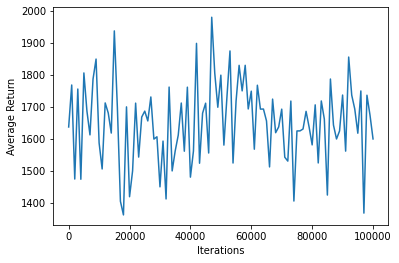

In [ ]:
env_name = "naive-rubiks-cube-222-v0" #@param {type:"string"}
fc_layer_params = (100 ,100, 100) #@param {type:"raw"}
activation_fn = tf.keras.activations.relu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}

num_iterations = 100000 # @param {type:"integer"} 

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 1000  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

optimizer = optimizer_type(learning_rate=learning_rate)



#Configurar, entrenar, y mostrar gráfica
train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(env_name, fc_layer_params, activation_fn,  dropout_layer_params, optimizer)
returns = train_environment(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration, eval_interval)
plot_training(num_iterations, eval_interval, returns)

create_policy_eval_video(agent.policy, "trained-agent")


Agregando parámetros gamma y epsilon. (https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent).

Gamma es para premiar el reward cercano vs el futuro, y epsilon para presionar la exploración mediante una probabilidad de tomar una acción aleatoria en el step. 

0 <= Gamma, Epsilon <= 1.

**Resultado**: aunque la pérdida es menor, el resultado es el mismo. Es de entender entonces que se debe cambiar la funcion de reward.

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  20400     
_________________________________________________________________
dense_75 (Dense)             multiple                  303       
Total params: 20,703
Trainable params: 20,703
Non-trainable params: 0
_________________________________________________________________
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs
step = 200: loss = 480.9880065917969
step = 400: loss = 298.2834777832031
step = 600: loss = 227.17930603027344
step = 800: loss = 552.082275390625
step = 1000: loss = 263.7676086425781
step = 1000: Average Return = 1618.4000244140625
step = 1200: loss = 615.1392211914062
step = 1400: loss = 7542.83740234375
step = 1600: loss = 11053920.0
step = 1800: loss = 10004.66015625
step = 2000: loss = 11856577.0
step = 2000: Average Return = 1619.099975

step = 50000: Average Return = 1606.0


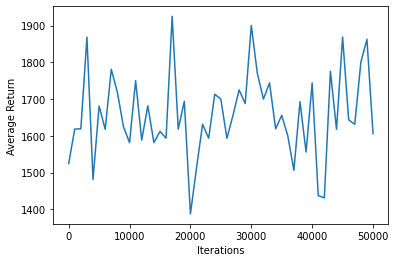

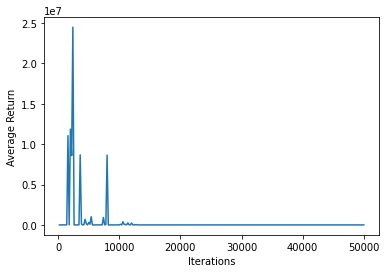

In [ ]:
env_name = "naive-rubiks-cube-222-v0" #@param {type:"string"}
fc_layer_params = (100 ,100, 100) #@param {type:"raw"}
activation_fn = tf.keras.activations.relu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}
gamma = 0.9 # @param {type:"number"}
epsilon_greedy = 0.1 # @param {type:"number"}

num_iterations = 50000 # @param {type:"integer"} 

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 50  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

optimizer = optimizer_type(learning_rate=learning_rate)



#Configurar, entrenar, y mostrar gráfica
train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(env_name, fc_layer_params, activation_fn,  dropout_layer_params, optimizer, gamma, epsilon_greedy)
returns, losses = train_environment(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration, eval_interval, log_interval)
plot_training(num_iterations, eval_interval, log_interval, returns, losses)

create_policy_eval_video(agent.policy, "trained-agent")


Ahora intentaremos con un cubo diferente, el reward function es igaul al naive, pero se hace override al reset para ver si se es capaz de aprender a organizar un cubo cuyo estado inicial es muy cerca de terminar.

**Resultado**: Con un estado inicial cerca de acabar, el algoritmo a prender a armar el cubo.

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  20400     
_________________________________________________________________
dense_43 (Dense)             multiple                  303       
Total params: 20,703
Trainable params: 20,703
Non-trainable params: 0
_________________________________________________________________
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
step = 200: loss = 37.96379470825195
step = 400: loss = 122.66249084472656
step = 600: loss = 62.999847412109375
step = 800: loss = 47.3492546081543
step = 1000: loss = 81.29489135742188
step = 1000: Average Return = 2872.0
step = 1200: loss = 104.68729400634766
step = 1400: loss = 67.7342758178711
step = 1600: loss = 58.781776428222656
step = 1800: loss = 67.72831726074219
step = 2000: loss = 56.03509521484375
step = 2000: Average Return = 287

step = 100000: loss = 329588.25
step = 100000: Average Return = 10032.0


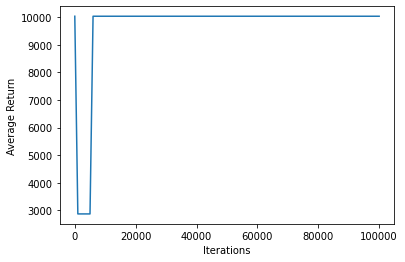

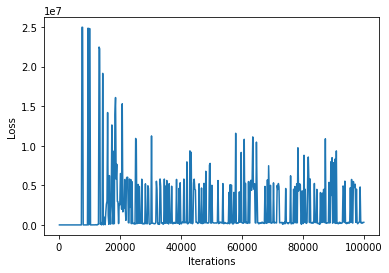

In [ ]:
env_name = "OneFaceFirstRubiksCube222-v6" #@param {type:"string"}
fc_layer_params = (100 ,100, 100) #@param {type:"raw"}
activation_fn = tf.keras.activations.relu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}
gamma = 0.9 # @param {type:"number"}
epsilon_greedy = 0.01 # @param {type:"number"}

num_iterations = 100000 # @param {type:"integer"} 

initial_collect_steps =   12# @param {type:"integer"} 
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size =   4# @param {type:"integer"}
learning_rate =   0.01# @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

optimizer = optimizer_type(learning_rate=learning_rate)



#Configurar, entrenar, y mostrar gráfica
train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(
    env_name = env_name, 
    fc_layer_params = fc_layer_params, 
    activation_fn = activation_fn,  
    dropout_layer_params = dropout_layer_params, 
    learning_rate = learning_rate,
    optimizer_type = optimizer_type, 
    gamma = gamma, 
    epsilon_greedy = epsilon_greedy)
returns, losses = train_environment(
    agent, 
    train_env, 
    eval_env, 
    replay_buffer, 
    iterator, 
    num_iterations, 
    num_eval_episodes, 
    collect_steps_per_iteration, 
    eval_interval, 
    log_interval)


plot_training(num_iterations, eval_interval, log_interval, returns, losses)
create_policy_eval_video(eval_env, agent.policy, "trained-agent")


Batch size = 15 (mirando el codigo) el reward maximo es armando la cara frontal)

**Resultado**: tampoco funciona, esta basado en el naive, necesitamos otra función de reward.

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  20400     
_________________________________________________________________
dense_75 (Dense)             multiple                  303       
Total params: 20,703
Trainable params: 20,703
Non-trainable params: 0
_________________________________________________________________
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs
step = 200: loss = 1280.024169921875
step = 400: loss = 1956.8890380859375
step = 600: loss = 328.8180847167969
step = 800: loss = 183.77960205078125
step = 1000: loss = 4669.6123046875
step = 1000: Average Return = 3424.0
step = 1200: loss = 1010.7235717773438
step = 1400: loss = 700.2428588867188
step = 1600: loss = 11106.50390625
step = 1800: loss = 18279.767578125
step = 2000: loss = 12299399.0
step = 2000: Average Return = 2141.60009765625
ste

step = 20000: Average Return = 1654.300048828125


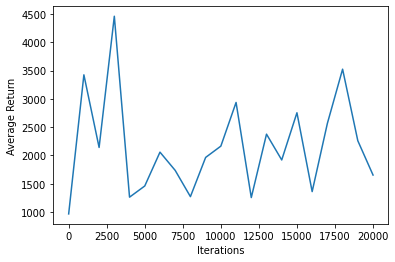

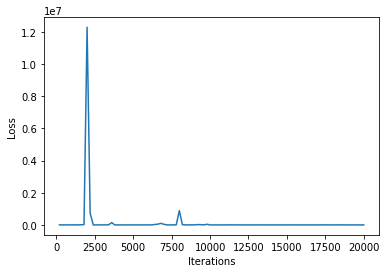

In [ ]:

env_name = "OneFaceFirstBRubiksCube222-v2" #@param {type:"string"}
fc_layer_params = (100 ,100, 100) #@param {type:"raw"}
activation_fn = tf.keras.activations.relu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}
gamma = 0.3 # @param {type:"number"}
epsilon_greedy = 0.8 # @param {type:"number"}

num_iterations = 20000 # @param {type:"integer"} 

initial_collect_steps =   15# @param {type:"integer"} 
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size =   15# @param {type:"integer"}
learning_rate =   0.01# @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

optimizer = optimizer_type(learning_rate=learning_rate)



#Configurar, entrenar, y mostrar gráfica
with tf.device('/device:GPU:0'):
  train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(
      env_name = env_name, 
      fc_layer_params = fc_layer_params, 
      activation_fn = activation_fn,  
      dropout_layer_params = dropout_layer_params, 
      learning_rate = learning_rate,
      optimizer_type = optimizer_type, 
      gamma = gamma, 
      epsilon_greedy = epsilon_greedy)
  returns, losses = train_environment(
      agent, 
      train_env, 
      eval_env, 
      replay_buffer, 
      iterator, 
      num_iterations, 
      num_eval_episodes, 
      collect_steps_per_iteration, 
      eval_interval, 
      log_interval)


plot_training(num_iterations, eval_interval, log_interval, returns, losses)
create_policy_eval_video(eval_env, agent.policy, "trained-agent")


Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  10300     
_________________________________________________________________
dense_120 (Dense)            multiple                  303       
Total params: 10,603
Trainable params: 10,603
Non-trainable params: 0
_________________________________________________________________
CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 17.2 µs
step = 2000: loss = 54.92586135864258
step = 4000: loss = 376.0172424316406
step = 6000: loss = 85.54883575439453
step = 8000: loss = 296.84722900390625
step = 10000: loss = 135.0910186767578
step = 10000: Average Return = 5004.10009765625
step = 12000: loss = 114.6760482788086
step = 14000: loss = 33.83928298950195
step = 16000: loss = 39.08115768432617
step = 18000: loss = 13.154739379882812
step = 20000: loss = 107.05368041992188
step = 20000: A

step = 200000: Average Return = 2336.10009765625


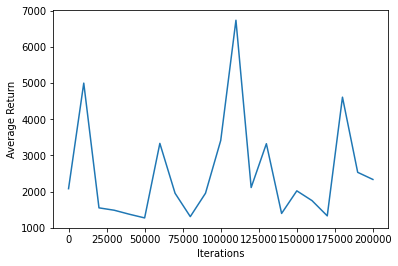

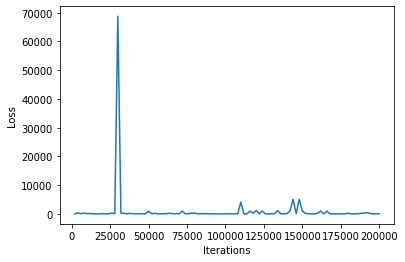

In [ ]:

env_name = "OneFaceFirstBRubiksCube222-v2" #@param {type:"string"}
fc_layer_params = (100 ,100) #@param {type:"raw"}
activation_fn = tf.keras.activations.relu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}
gamma = 0.8 # @param {type:"number"}
epsilon_greedy = 0.8 # @param {type:"number"}

num_iterations = 200000 # @param {type:"integer"} 

initial_collect_steps =   15# @param {type:"integer"} 
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size =   15# @param {type:"integer"}
learning_rate =   0.1# @param {type:"number"}
log_interval = 2000  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 10000  # @param {type:"integer"}

optimizer = optimizer_type(learning_rate=learning_rate)



#Configurar, entrenar, y mostrar gráfica
with tf.device('/device:GPU:0'):
  train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(
      env_name = env_name, 
      fc_layer_params = fc_layer_params, 
      activation_fn = activation_fn,  
      dropout_layer_params = dropout_layer_params, 
      learning_rate = learning_rate,
      optimizer_type = optimizer_type, 
      gamma = gamma, 
      epsilon_greedy = epsilon_greedy)
  returns, losses = train_environment(
      agent, 
      train_env, 
      eval_env, 
      replay_buffer, 
      iterator, 
      num_iterations, 
      num_eval_episodes, 
      collect_steps_per_iteration, 
      eval_interval, 
      log_interval)


plot_training(num_iterations, eval_interval, log_interval, returns, losses)
create_policy_eval_video(eval_env, agent.policy, "trained-agent")


Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  2134912   
_________________________________________________________________
dense_86 (Dense)             multiple                  387       
Total params: 2,135,299
Trainable params: 2,135,299
Non-trainable params: 0
_________________________________________________________________
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
step = 1000: loss = 195099200.0
step = 2000: loss = 117921480704.0
step = 2000: Average Return = 21644.599609375
step = 3000: loss = 264507.90625
step = 4000: loss = 176721040.0
step = 4000: Average Return = 2388.0
step = 5000: loss = 46322.9375
step = 6000: loss = 871314.75
step = 6000: Average Return = 23056.099609375
step = 7000: loss = 5750349.0
step = 8000: loss = 5749999.5
step = 8000: Average Return = 4915.2998046875
step = 9000: loss 

step = 100000: Average Return = 5431.60009765625


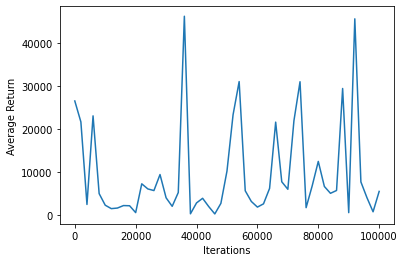

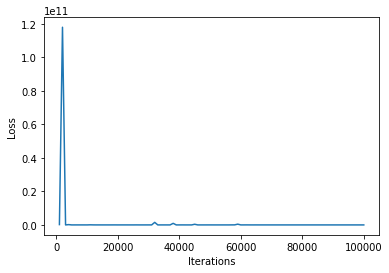

In [ ]:
 
env_name = "VerticesRubiksCube222-v13" #@param {type:"string"}
fc_layer_params = (1024,1024,512,512,256,256,256,128) #@param {type:"raw"}
activation_fn = tf.keras.activations.selu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}
gamma = 0.9 # @param {type:"number"}
epsilon_greedy =  0.3# @param {type:"number"}
 
num_iterations = 100000 # @param {type:"integer"} 
 
initial_collect_steps =   4# @param {type:"integer"} 
collect_steps_per_iteration =   4# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
 
batch_size =   256# @param {type:"integer"}
learning_rate =   1e-4# @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}
 
num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 2000  # @param {type:"integer"}
 
optimizer = optimizer_type(learning_rate=learning_rate)
 
 
 
#Configurar, entrenar, y mostrar gráfica
with tf.device('/device:GPU:0'):
  train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(
      env_name = env_name, 
      fc_layer_params = fc_layer_params, 
      activation_fn = activation_fn,  
      dropout_layer_params = dropout_layer_params, 
      learning_rate = learning_rate,
      optimizer_type = optimizer_type, 
      gamma = gamma, 
      epsilon_greedy = epsilon_greedy)
  returns, losses = train_environment(
      agent, 
      train_env, 
      eval_env, 
      replay_buffer, 
      iterator, 
      num_iterations, 
      num_eval_episodes, 
      collect_steps_per_iteration, 
      eval_interval, 
      log_interval)
 
 
plot_training(num_iterations, eval_interval, log_interval, returns, losses)
create_policy_eval_video(eval_env, agent.policy, "trained-agent")

In [ ]:

env_name = "VerticesRubiksCube222-v15" #@param {type:"string"}
fc_layer_params = (1024,1024,512,512,256,256,256,128) #@param {type:"raw"}
activation_fn = tf.keras.activations.selu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}
gamma = 0.9 # @param {type:"number"}
epsilon_greedy =  0.3# @param {type:"number"}

num_iterations = 100000 # @param {type:"integer"} 

initial_collect_steps =   400# @param {type:"integer"} 
collect_steps_per_iteration =   100# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size =   1000# @param {type:"integer"}
learning_rate =   1e-5# @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes =   3# @param {type:"integer"}
eval_interval = 5000  # @param {type:"integer"}

optimizer = optimizer_type(learning_rate=learning_rate)



#Configurar, entrenar, y mostrar gráfica
with tf.device('/device:GPU:0'):
  train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(
      env_name = env_name, 
      fc_layer_params = fc_layer_params, 
      activation_fn = activation_fn,  
      dropout_layer_params = dropout_layer_params, 
      learning_rate = learning_rate,
      optimizer_type = optimizer_type, 
      gamma = gamma, 
      epsilon_greedy = epsilon_greedy)
  returns, losses = train_environment(
      agent, 
      train_env, 
      eval_env, 
      replay_buffer, 
      iterator, 
      num_iterations, 
      num_eval_episodes, 
      collect_steps_per_iteration, 
      eval_interval, 
      log_interval)


plot_training(num_iterations, eval_interval, log_interval, returns, losses)
create_policy_eval_video(eval_env, agent.policy, "trained-agent")

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  2134912   
_________________________________________________________________
dense_248 (Dense)            multiple                  387       
Total params: 2,135,299
Trainable params: 2,135,299
Non-trainable params: 0
_________________________________________________________________
CPU times: user 10 µs, sys: 1e+03 ns, total: 11 µs
Wall time: 20.3 µs
step = 1000: loss = 120661.0234375
step = 2000: loss = 938.600341796875
step = 3000: loss = 4718.86962890625
step = 4000: loss = 20649108.0
step = 5000: loss = 4384.087890625
step = 5000: Average Return = 3174.333251953125
step = 6000: loss = 135339360.0
step = 7000: loss = 864054.75
step = 8000: loss = 2615.677978515625
step = 9000: loss = 34427052.0
step = 10000: loss = 4697.7939453125
step = 10000: Average Return = 3215.666748046875
